In this notebook I compute the frequency of which pixels exceed certain precipitation intensity threshold. This could be an indication 

In [49]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from skimage import morphology

import netCDF4

from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import cv2
import radarplot

In [2]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_aart_np/'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.startswith('2019')])
print(len(files))

105119


In [3]:
# Threshold values in 0.01mm
# 0.3mm, 3mm, 30mm, 100mm (50dBZ) heavy rain/small hail, 200mm (~60dBZ) extreme hail
thresholds = [30, 300, 3000, 10000, 20000] 

In [39]:
55739/430831

0.12937555561229344

In [33]:
dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'

path = dir_aart + aart_fbase + '201901010000.nc'
with netCDF4.Dataset(path, 'r') as ds:
    rain = ds['image1_image_data'][:]
    mask = rain.mask
mask_size = np.sum(~mask)
print(mask_size)
print(rain.shape, np.prod(rain.shape))
print(100*mask_size/np.prod(rain.shape))
print(mask)

55739
(1, 765, 700) 535500
10.408776844070962
[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]]


In [47]:
def filter_clutter(img, threshold=30):
    '''
    Removes isolated pixels. Pixel is isolated if it has rain but no rainy neighbours.
    img: image to be preprocessed
    threshold: threshold for rain no rain, default is 0.3mm (30)
    '''
    rainy = (img > threshold).astype('uint8')
    # Set pixels below threshold to 0
    preprocessed = img*rainy
    
    # Create kernel that checks if pixel has no rainy neighbours
    kernel_size=3
    kernel = -np.ones((kernel_size,kernel_size))
    kernel[1,1] = 1
    
    # Move kernel over image
    isolated_pixels = cv2.morphologyEx(rainy, cv2.MORPH_HITMISS, kernel)
    # Remove isolated pixels 
    output = preprocessed * np.logical_not(isolated_pixels)
    
    return output


In [57]:
count_exceed = np.zeros((len(thresholds), 765,700))
count_sum = 0
error_count=0
max_val = 0
for f in tqdm(files):
    try:
        rdr = np.load(radar_dir+f)
        rdr[rdr==6553500] = 0
        if rdr[0][0] != 0:
            print(rdr[0][0])
        
        rdr = filter_clutter(rdr)
        count_sum += 1
    except Exception as e:
        print(e)
        rain = False
        error_count=+1
        rdr = np.zeros((765,700))
        
    
    for i, thresh in enumerate(thresholds):
        count_exceed[i] += rdr>thresh
    if np.max(rdr) > max_val:
        max_val=np.max(rdr)


100%|██████████| 105119/105119 [1:39:03<00:00, 17.69it/s]


In [52]:
count_sum

100

In [4]:
count_exceed = np.load('aart_clutter.npy')

In [25]:
print('Errors: ', error_count)
print(max_val)

Errors:  0
18494


In [26]:
max_val

18494

Text(0.5, 1.0, '> 0.3mm')

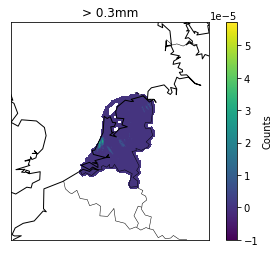

In [56]:
i=0
plot_on_map(count_exceed[i]/105119, ftype='.nc')
plt.title('> {}mm'.format(thresholds[i]/100))

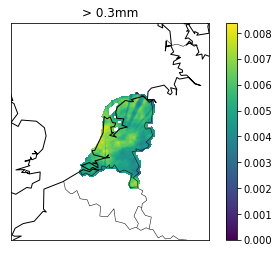

In [7]:
i=0
plot_on_map(count_exceed[i]/105119, ftype='.nc')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/aart_freq_above_03mm')

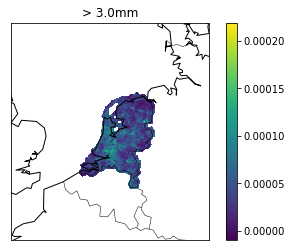

In [9]:
i=1
plot_on_map(count_exceed[i]/105119, ftype='.nc')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/aart_freq_above_3mm')

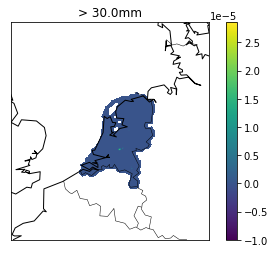

In [10]:
i=2
plot_on_map(count_exceed[i]/105119, ftype='.nc')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/aart_freq_above_30mm')

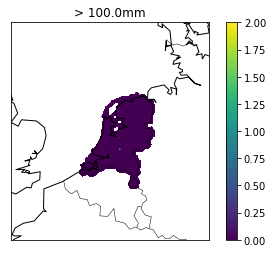

In [11]:
i=3
plot_on_map(count_exceed[i], ftype='.nc')
plt.title('> {}mm'.format(thresholds[i]/100))
plt.savefig('figures/aart_freq_above_100mm')

<ipython-input-9-4ce9354d1def>:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


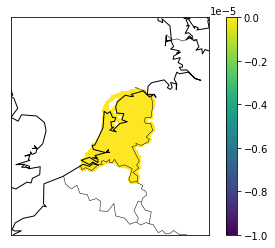